In [1]:
from oggm import cfg, utils, workflow, tasks, graphics
from oggm.core import climate, massbalance, flowline
from oggm.shop import gcm_climate, bedtopo

import matplotlib.pyplot as plt
import xarray as xr
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import os 

# oggm initialzation
cfg.initialize(logging_level='WARNING')
cfg.PARAMS['use_multiprocessing']=True
cfg.PATHS['working_dir'] = '/home/lucillegimenes/oggm-workflow-b/'
cfg.PARAMS['continue_on_error'] = True
#cfg.PARAMS['run_mb_calibration'] = True

rgi_ids = ['RGI60-13.37753'] 
gdirs = workflow.init_glacier_directories(rgi_ids,from_prepro_level=2,prepro_rgi_version=62,prepro_border=80)
gdir=gdirs[0]
newname=''


2021-11-22 10:56:32: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-11-22 10:56:32: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2021-11-22 10:56:32: oggm.cfg: Multiprocessing: using all available processors (N=8)
2021-11-22 10:56:32: oggm.cfg: Multiprocessing switched ON after user settings.
2021-11-22 10:56:32: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2021-11-22 10:56:33: oggm.workflow: init_glacier_directories from prepro level 2 on 1 glaciers.
2021-11-22 10:56:33: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
100% of 199.6 MiB |######################| Elapsed Time: 0:01:04 Time:  0:01:04


In [2]:
#pre-processing tasks
prepro_task_list = [
    
        tasks.glacier_masks,  
        tasks.compute_centerlines,
        tasks.initialize_flowlines,
        tasks.compute_downstream_line,
        tasks.compute_downstream_bedshape,
        tasks.catchment_area,
        tasks.catchment_intersections,
        tasks.catchment_width_geom,
        tasks.catchment_width_correction   
        ]
for task in prepro_task_list:
    workflow.execute_entity_task(task, gdir)

2021-11-22 10:58:35: oggm.workflow: Execute entity tasks [glacier_masks] on 1 glaciers
2021-11-22 10:58:36: oggm.workflow: Execute entity tasks [compute_centerlines] on 1 glaciers
2021-11-22 10:58:36: oggm.workflow: Execute entity tasks [initialize_flowlines] on 1 glaciers
2021-11-22 10:58:36: oggm.workflow: Execute entity tasks [compute_downstream_line] on 1 glaciers
2021-11-22 10:58:37: oggm.workflow: Execute entity tasks [compute_downstream_bedshape] on 1 glaciers
2021-11-22 10:58:37: oggm.workflow: Execute entity tasks [catchment_area] on 1 glaciers
2021-11-22 10:58:39: oggm.workflow: Execute entity tasks [catchment_intersections] on 1 glaciers
2021-11-22 10:58:39: oggm.workflow: Execute entity tasks [catchment_width_geom] on 1 glaciers
2021-11-22 10:58:42: oggm.workflow: Execute entity tasks [catchment_width_correction] on 1 glaciers


In [3]:
#climate tasks 
tasks.process_climate_data(gdir)
params_url = 'https://cluster.klima.uni-bremen.de/~oggm/ref_mb_params/oggm_v1.4/RGIV62/CRU/centerlines/qc3/pcp2.5'
workflow.download_ref_tstars(base_url=params_url)

climate_task_list = [
        tasks.local_t_star,     
        tasks.mu_star_calibration
        ]

for task in climate_task_list:
        workflow.execute_entity_task(task, gdir)

2021-11-22 10:58:48: oggm.workflow: Execute entity tasks [local_t_star] on 1 glaciers
2021-11-22 10:58:48: oggm.workflow: Execute entity tasks [mu_star_calibration] on 1 glaciers


2021-11-22 10:58:50: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-13/RGI60-13.37/RGI60-13.37753/outflow.shp ...
2021-11-22 10:58:50: oggm.workflow: Execute entity tasks [_get_centerline_lonlat] on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<AxesSubplot:>

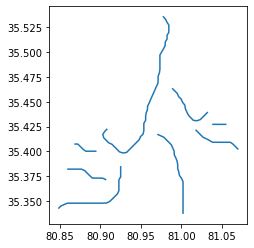

In [4]:
import write_to_shape 
#converting flowlines to shapefile 
path_to_shp='/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-'+gdir.rgi_region+'/'+gdir.rgi_id[0:11]+'/'+gdir.rgi_id+'/outflow.shp'
write_to_shape.write_centerlines_to_shape_bis(gdir, path=path_to_shp,flowlines_output=True)
sh = gpd.read_file(path_to_shp)
sh.plot()




In [5]:
#download and process gcm data
#precipitations
bp = 'https://cluster.klima.uni-bremen.de/~oggm/cmip5-ng/pr/pr_mon_CCSM4_{}_r1i1p1_g025.nc'
#temperatures
bt = 'https://cluster.klima.uni-bremen.de/~oggm/cmip5-ng/tas/tas_mon_CCSM4_{}_r1i1p1_g025.nc'

In [6]:
cfg.add_to_basenames('model_geometry_my_spinup','model_geometry_my_spinup.nc')
cfg.add_to_basenames('model_geometry_with_spinup','model_geometry_with_spinup.nc')
for rcp in ['rcp26','rcp45','rcp60','rcp85']:
    cfg.add_to_basenames('model_geometry_CCSM4_'+rcp+'','model_geometry_CCSM4_'+rcp+'.nc')
    cfg.add_to_basenames('model_diagnostics_CCSM4_'+rcp+'','model_diagnostics_CCSM4_'+rcp+'.nc')

In [7]:
gdir.name_corr=gdir.name.replace('/','-')
if (gdir.name==''):
    gdir.name_corr='Aletsch'

In [8]:
import pickle
import thickness_init
import add_data
import graph
import matplotlib
import statistics as stc
from matplotlib import cm as colormap
from oggm.workflow import execute_entity_task
import imageio
from __future__ import division
from scipy import *                 
from pylab import *
import os

import time

cfg.PARAMS['store_model_geometry'] = True

# start time !
start_time = time.time()

list_out_surf=[0]*3 #pre allocate for plotting profile (temporary)
list_out_bed=[0]*3
list_out_surf_evol=[0]*9
list_out_bed_evol=[0]*3


out_evol={'oggm':[0]*4,'farinotti':[0]*4,'millan':[0]*4}
out_evol_no_spin = {'oggm':[0]*4,'farinotti':[0]*4,'millan':[0]*4}
out_evol_m02 = {'oggm':[0]*4,'farinotti':[0]*4,'millan':[0]*4}
out_evol_p02 = {'oggm':[0]*4,'farinotti':[0]*4,'millan':[0]*4}
out_evol_m04 = {'oggm':[0]*4,'farinotti':[0]*4,'millan':[0]*4}
out_evol_p04 = {'oggm':[0]*4,'farinotti':[0]*4,'millan':[0]*4}


out_hydro_hist = {'oggm':0,'farinotti':0,'millan':0}

d_spin = {'oggm':0,'farinotti':0,'millan':0}

d_=[0,0,0]


orig_cmap = matplotlib.cm.RdBu

if (gdir.rgi_region in ['13','14','15']):
    gdir.rgi_region_m='13-15'
else:
    gdir.rgi_region_m=gdir.rgi_region

    
data_list=['oggm','farinotti','millan']
k=0 
for data in data_list:
    print(data)
    ##### Initial thickness ######
    workflow.execute_entity_task(tasks.prepare_for_inversion, gdir)
    
    if (data=='millan') or (data=='farinotti'):
        
        #checking if we have the right number of points on the flowlines
        cls=gdir.read_pickle('inversion_input')
        path_to_pkl='/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-'+gdir.rgi_region+'/'+gdir.rgi_id[0:11]+'/'+gdir.rgi_id+'/db_'+data+'.pkl'
        with open(path_to_pkl, 'rb') as db_file:
            data_test = pickle.load(db_file)

        ind=0
        for i in range(0,len(data_test)):
            if (len(cls[i]['width'])!=len(data_test[i])):
                ind+=1
        if (ind==0):
            print('Extraction OK')
        else:
            print('Problème extraction')
        
        #creating 'inversion_output.pkl'
        path_to_pkl='/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-'+gdir.rgi_region+'/'+gdir.rgi_id[0:11]+'/'+gdir.rgi_id+'/db_'+data+'.pkl'
        thickness_init.ice_thickness_from_data(gdir,data_file=path_to_pkl)

    else:
        workflow.execute_entity_task(tasks.mass_conservation_inversion,gdir)

    workflow.execute_entity_task(tasks.filter_inversion_output,gdir)
    
    """max_thick=0
    cls=gdir.read_pickle('inversion_output')
    for m in range(0,len(cls)):
        if (max(cls[m]['thick'])>max_thick):
            max_thick=max(cls[m]['thick'])

    #thicknesses along the flowlines
    #graphics.plot_inversion(gdir, figsize=(8, 7))
    #name = ''+gdir.name_corr+'_thick_widths_'+data+'.png'
    #plt.savefig(name, format = 'png')
    
    #cosmetic task
    workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdir);

    if (data=='farinotti'):
        workflow.execute_entity_task(bedtopo.add_consensus_thickness, gdir);
        add_data.mapped_extracted_thickness(gdir)
    elif (data=='millan'):
        add_data.add_data_thickness(gdir,'/home/lucillegimenes/Bureau/THICKNESS_Millan/RGI-'+gdir.rgi_region_m+'/per_glacier/'+gdir.rgi_id+'_thickness_m_from_f.tif')
        add_data.mapped_extracted_thickness(gdir)
        
    with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
        ds = ds.load()
        
    if(data=='farinotti'):
        compare_data=ds.consensus_ice_thickness
    elif(data=='millan'):
        compare_data=ds.millan_thickness
    else:
        save_oggm=ds.distributed_thickness
    # Distributed thickness from data
    #smap = ds.salem.get_map(countries=False)
    #smap.set_shapefile(gdir.read_shapefile('outlines'))
    #smap.set_topography(ds.topo.data);
    #f, ax = plt.subplots(figsize=(9, 9))
    #smap.set_data(ds.distributed_thickness)
    #smap.set_cmap('Blues')
    #smap.plot(ax=ax)
    #smap.append_colorbar(ax=ax, label='ice thickness (m)');
    #name = ''+gdir.name_corr+'_thick_distributed_'+data+'.png'
    #plt.savefig(name, format = 'png')"""
    

    #if (data=='farinotti') or (data=='millan'):
            
    """f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7)= plt.subplots(1, 7, figsize=(65, 15))
        
        #Original map 
        smap = ds.salem.get_map(countries=False)
        smap.set_shapefile(gdir.read_shapefile('outlines'))
        smap.set_topography(ds.topo.data);
        smap.set_data(compare_data)
        smap.set_cmap('Blues')
        #smap.set_vmax(val=max_thick)
        smap.plot(ax=ax1)
        smap.visualize(ax=ax1,title='Original map')
        #smap.append_colorbar(ax=ax1, label='ice thickness (m)');
        
        #Thickness along flowline (widths)
        graphics.plot_inversion(gdir,ax=ax2)
        plt.title('Thickness along flowlines')
        
        
        #Thickness distributed after prescription from data source (f or m)
        smap3 = ds.salem.get_map(countries=False)
        smap3.set_shapefile(gdir.read_shapefile('outlines'))
        smap3.set_topography(ds.topo.data);
        smap3.set_data(ds.distributed_thickness)
        #smapf.set_vmax(val=max_thick)
        smap3.set_cmap('Blues')
        smap3.plot(ax=ax3)
        smap3.visualize(ax=ax3,title='Distributed thickness')

        
        #Difference btw thickness directly from source and the one after distribution 
        smap4 = ds.salem.get_map(countries=False)
        smap4.set_shapefile(gdir.read_shapefile('outlines'))
        smap4.set_topography(ds.topo.data);
        smap4.set_data(compare_data-ds.distributed_thickness)
        prop=abs(np.min(compare_data-ds.distributed_thickness))/(np.max(compare_data-ds.distributed_thickness)+abs(np.min(compare_data-ds.distributed_thickness)))
        propf=prop.astype(np.float)
        shifted_cmap = graph.shiftedColorMap(orig_cmap, midpoint=propf, name='shifted')
        smap4.set_cmap(shifted_cmap)
        smap4.set_vmax(val=100)
        smap4.set_vmin(val=-100)
        smap4.plot(ax=ax4)
        smap4.visualize(ax=ax4,title='Difference between distributed and original thickness')
        #smapp.append_colorbar(ax=ax4, label='ice thickness (m)');
        ax11 = f.add_axes([0.47, 0.28, 0.034, 0.101])
        ax11.set_yticklabels([])
        var=compare_data-ds.distributed_thickness
        var.plot.hist(bins=25,edgecolor='k',density=True)
        plt.axvline(var.mean(), color='k', linestyle='dashed', linewidth=1)
        plt.axvline(var.median(), color='r', linestyle='dashed', linewidth=1)
        std=float(var.std())
        plt.title('std: {:.2f}'.format(std))
        
        
        #Difference btw thickness directly from source and the one after extraction
        smap5 = ds.salem.get_map(countries=False)
        smap5.set_shapefile(gdir.read_shapefile('outlines'))
        smap5.set_topography(ds.topo.data);
        smap5.set_data(compare_data-ds.extracted_thickness)
        prop=abs(np.min(compare_data-ds.extracted_thickness))/(np.max(compare_data-ds.extracted_thickness)+abs(np.min(compare_data-ds.extracted_thickness)))
        propf=prop.astype(np.float)
        shifted_cmap2 = graph.shiftedColorMap(orig_cmap, midpoint=propf, name='shifted')
        smap5.set_cmap(shifted_cmap2)
        smap5.plot(ax=ax5)
        smap5.visualize(ax=ax5,title='Difference between original and extracted thicknesses')
        ax12 = f.add_axes([0.59, 0.28, 0.034, 0.101])
        ax12.set_yticklabels([])
        var=compare_data-ds.extracted_thickness_hist
        var.plot.hist(bins=25,edgecolor='k',density=True)
        plt.axvline(var.mean(), color='k', linestyle='dashed', linewidth=1)
        plt.axvline(var.median(), color='r', linestyle='dashed', linewidth=1)
        std=float(var.std())
        plt.title('std: {:.2f}'.format(std))
        

        #Distributed thickness only from oogm 
        smap6 = ds.salem.get_map(countries=False)
        smap6.set_shapefile(gdir.read_shapefile('outlines'))
        smap6.set_topography(ds.topo.data);
        smap6.set_data(save_oggm)
        smap6.set_cmap('Blues')
        #smapl.set_vmax(val=max_thick)
        smap6.plot(ax=ax6)
        smap6.visualize(ax=ax6,title='distributed thickness from oggm')
        
        #Difference between distributed from source and from oggm
        smap7 = ds.salem.get_map(countries=False)
        smap7.set_shapefile(gdir.read_shapefile('outlines'))
        smap7.set_topography(ds.topo.data);
        smap7.set_data(save_oggm-ds.distributed_thickness)
        prop=abs(np.min(save_oggm-ds.distributed_thickness))/(np.max(save_oggm-ds.distributed_thickness)+abs(np.min(save_oggm-ds.distributed_thickness)))
        propf=prop.astype(np.float)
        shifted_cmap = graph.shiftedColorMap(orig_cmap, midpoint=propf, name='shifted')
        smap7.set_cmap(shifted_cmap)
        smap7.set_vmax(val=100)
        smap7.set_vmin(val=-100)
        smap7.plot(ax=ax7)
        smap7.visualize(ax=ax7,title='Difference between distributed from oggm and from '+data+'')
        #smapp.append_colorbar(ax=ax4, label='ice thickness (m)');
        ax13 = f.add_axes([0.81, 0.28, 0.034, 0.101])
        ax13.set_yticklabels([])
        var=save_oggm-ds.distributed_thickness
        var.plot.hist(bins=25,edgecolor='k',density=True)
        plt.axvline(var.mean(), color='k', linestyle='dashed', linewidth=1)
        plt.axvline(var.median(), color='r', linestyle='dashed', linewidth=1)
        std=float(var.std())
        plt.title('std: {:.2f}'.format(std))
        
        
        
        name = ''+gdir.name_corr+'_'+data+'_panel.png'
        plt.savefig(name, format = 'png')"""
        
    
    for sp in ['spin','nospin']:
        ###### Spin-up ######    
        #initialization 
        workflow.execute_entity_task(tasks.init_present_time_glacier, gdir) 

        if (sp=='spin'):

            #Run the spinup simulation - t* climate    
            workflow.execute_entity_task(tasks.run_constant_climate, gdir,nyears=300,output_filesuffix='_my_spinup') 

            utils.compile_glacier_statistics(gdir)
            d_[k] = utils.compile_run_output(gdir, input_filesuffix='_my_spinup')


            # Run a past climate run based on this spinup
            execute_entity_task(tasks.run_with_hydro, gdir, run_task=tasks.run_from_climate_data,
                                climate_filename='climate_historical',
                                ys=2003, ye=2020,init_model_filesuffix='_my_spinup',
                                output_filesuffix='_with_spinup',store_monthly_hydro=True)
            
            with xr.open_dataset(gdir.get_filepath('model_diagnostics',filesuffix='_with_spinup')) as dh:
                dh = dh.load()
            out_hydro_hist[data]=dh
            
        elif(sp=='nospin'):

                # Run a past climate run based on this spinup
            execute_entity_task(tasks.run_with_hydro, gdir, run_task=tasks.run_from_climate_data,
                                    climate_filename='climate_historical',
                                    ys=2003, ye=2020,
                                    output_filesuffix='_with_spinup',store_monthly_hydro=True)
            
        elif(sp=='m02'):
             #Run the spinup simulation - t* climate    
            workflow.execute_entity_task(tasks.run_constant_climate, gdir,nyears=300,
                                         temperature_bias=-0.2, output_filesuffix='_my_spinup') 

                # Run a past climate run based on this spinup
            execute_entity_task(tasks.run_with_hydro, gdir, run_task=tasks.run_from_climate_data,
                                    climate_filename='climate_historical',
                                    ys=2003, ye=2020,init_model_filesuffix='_my_spinup',
                                    output_filesuffix='_with_spinup',store_monthly_hydro=True)
            
        elif(sp=='p02'):
             #Run the spinup simulation - t* climate    
            workflow.execute_entity_task(tasks.run_constant_climate, gdir,nyears=300,
                                         temperature_bias=+0.2, output_filesuffix='_my_spinup') 

                # Run a past climate run based on this spinup
            execute_entity_task(tasks.run_with_hydro, gdir, run_task=tasks.run_from_climate_data,
                                    climate_filename='climate_historical',
                                    ys=2003, ye=2020,init_model_filesuffix='_my_spinup',
                                    output_filesuffix='_with_spinup',store_monthly_hydro=True)
        elif (sp=='m04'):
             #Run the spinup simulation - t* climate    
            workflow.execute_entity_task(tasks.run_constant_climate, gdir,nyears=300,
                                         temperature_bias=-0.4, output_filesuffix='_my_spinup') 

                # Run a past climate run based on this spinup
            execute_entity_task(tasks.run_with_hydro, gdir, run_task=tasks.run_from_climate_data,
                                    climate_filename='climate_historical',
                                    ys=2003, ye=2020,init_model_filesuffix='_my_spinup',
                                    output_filesuffix='_with_spinup',store_monthly_hydro=True)
        elif(sp=='p04'):
             #Run the spinup simulation - t* climate    
            workflow.execute_entity_task(tasks.run_constant_climate, gdir,nyears=300,
                                         temperature_bias=0.4, output_filesuffix='_my_spinup') 

                # Run a past climate run based on this spinup
            execute_entity_task(tasks.run_with_hydro, gdir, run_task=tasks.run_from_climate_data,
                                    climate_filename='climate_historical',
                                    ys=2003, ye=2020,init_model_filesuffix='_my_spinup',
                                    output_filesuffix='_with_spinup',store_monthly_hydro=True)

        #For plotting a profile
        """fmod = flowline.FileModel(gdir.get_filepath('model_geometry_with_spinup'))
        fl = fmod.fls[-1]  # Main flowline
        i, j = fl.line.xy  # xy flowline on grid
        lons, lats = gdir.grid.ij_to_crs(i, j, crs='EPSG:4326')  # to WGS84

        df_coords = pd.DataFrame(index=fl.dis_on_line*gdir.grid.dx)
        df_coords.index.name = 'Distance along flowline'
        df_coords['lon'] = lons
        df_coords['lat'] = lats
        df_coords['bed_elevation'] = fl.bed_h

        df_thick = pd.DataFrame(index=df_coords.index)
        df_surf_h = pd.DataFrame(index=df_coords.index)
        df_bed_h = pd.DataFrame()

        for year in range(2003, 2005):
            fmod.run_until(year)
            fl = fmod.fls[-1]
            df_thick[year] = fl.thick
            df_surf_h[year] = fl.surface_h

        list_out_surf[k]= df_surf_h[[2003]]
        list_out_bed[k]=df_coords['bed_elevation']"""

        ##### Simulations ####

        for rcp in ['rcp26', 'rcp45', 'rcp60', 'rcp85']:
            # read the path to the files, not opening with xr.opendataset()
            ft = utils.file_downloader(bt.format(rcp))
            fp = utils.file_downloader(bp.format(rcp))

            # bias correct them
            workflow.execute_entity_task(gcm_climate.process_cmip_data, gdir, 
                                         filesuffix='_CCSM4_{}'.format(rcp),             # recognize the climate file for later
                                         fpath_temp=ft,                                  # temperature projections
                                         fpath_precip=fp,                                # precip projections
                                         );  


            #projection run (starting from the end year of the historical run)
        for rcp in ['rcp26', 'rcp45', 'rcp60', 'rcp85']:
            rid = '_CCSM4_{}'.format(rcp)
            # with hydro                                
            workflow.execute_entity_task(tasks.run_with_hydro, gdir, ys=2019,
                                         run_task=tasks.run_from_climate_data,
                                         climate_filename='gcm_data',                    # use gcm_data, not climate_historical
                                         climate_input_filesuffix=rid,                   # use the chosen scenario
                                         init_model_filesuffix='_with_spinup',             # this is important! Start from 2020 glacier
                                         output_filesuffix=rid,                          # recognize the run for later
                                         store_monthly_hydro=True,
                                        );

        # end of the run                                  
        print('Simulation finished sucessfully')
    
    
        """fmod2 = flowline.FileModel(gdir.get_filepath('model_geometry_CCSM4_rcp45'))
        fl2 = fmod2.fls[-1]  # Main flowline
        i2, j2 = fl2.line.xy  # xy flowline on grid
        lons2, lats2 = gdir.grid.ij_to_crs(i2, j2, crs='EPSG:4326')  # to WGS84


        df_coords2 = pd.DataFrame(index=fl2.dis_on_line*gdir.grid.dx)
        df_coords2.index.name = 'Distance along flowline'
        df_coords2['lon'] = lons2
        df_coords2['lat'] = lats2
        df_coords2['bed_elevation'] = fl2.bed_h

        df_thick2 = pd.DataFrame(index=df_coords2.index)
        df_surf_h2 = pd.DataFrame(index=df_coords2.index)
        df_bed_h2 = pd.DataFrame()

        for year in range(2020, 2101):
            fmod2.run_until(year)
            fl2 = fmod2.fls[-1]
            df_thick2[year] = fl2.thick
            df_surf_h2[year] = fl2.surface_h

        list_out_surf_evol[k]= [df_surf_h2[[2020]],df_surf_h2[[2030]], df_surf_h2[[2040]],df_surf_h2[[2050]],
                                df_surf_h2[[2060]],df_surf_h2[[2070]],df_surf_h2[[2080]],df_surf_h2[[2090]]]
        list_out_bed_evol[k]=df_coords2['bed_elevation']"""

        # compile & plot the results
        #f, ax = plt.subplots(figsize=(8, 7))
        r=0
        for rcp in ['rcp26', 'rcp45', 'rcp60', 'rcp85']:
            rid = '_CCSM4_{}'.format(rcp)

            dsf = utils.compile_run_output(gdir, input_filesuffix=rid) 
            #for later plotting use
            if (sp=='spin'):
                out_evol[data][r]=dsf
            elif (sp=='nospin'):
                out_evol_no_spin[data][r]=dsf
            elif (sp=='m02'):
                out_evol_m02[data][r]=dsf
            elif(sp=='p02'):
                out_evol_p02[data][r]=dsf
            elif(sp=='m04'):
                out_evol_m04[data][r]=dsf
            elif(sp=='p04'):
                out_evol_p04[data][r]=dsf

            #dsf.volume.plot(ax=ax,label=rcp)
            r+=1


        # Construction d'une série d'images et de leur assemblage dans une animation
        """"filenames=[]
        for ygif in range(2020,2100,2):
            f, ax = plt.subplots(figsize=(8, 8))
            graphics.plot_modeloutput_map(gdir, filesuffix='_CCSM4_{}'.format('rcp45'), modelyr=ygif, ax=ax,vmax=max_thick)
            filename = 'f'+str('%02d' %ygif)+'.png'
            filenames.append(filename)
            plt.savefig(filename)
            plt.close()

                # build gif
        with imageio.get_writer('thickness_'+data+'.gif', mode='I', duration=0.2) as writer:
            for filename in filenames:
                image = imageio.imread(filename)
                writer.append_data(image)

        # Remove files
        for filename in set(filenames):
            os.remove(filename)"""

    
    #f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    #graphics.plot_modeloutput_map(gdir, filesuffix='_CCSM4_{}'.format('rcp45'), modelyr=2020, ax=ax1,vmax=max_thick)
    #graphics.plot_modeloutput_map(gdir, filesuffix='_CCSM4_{}'.format('rcp45'), modelyr=2050, ax=ax2,vmax=max_thick)
    #graphics.plot_modeloutput_map(gdir, filesuffix='_CCSM4_{}'.format('rcp45'), modelyr=2100, ax=ax3,vmax=max_thick)
    #plt.tight_layout();
    #name = ''+gdir.name_corr+'_evol_thick_rcp45_'+data+'.png'
    #plt.savefig(name, format = 'png')
    
    k+=1
    

print('Duration is')
print("--- %s seconds ---" % (time.time() - start_time))


2021-11-22 11:00:17: oggm.cfg: PARAMS['store_model_geometry'] changed from `False` to `True`.
2021-11-22 11:00:17: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-22 11:00:17: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-22 11:00:17: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-22 11:00:17: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-22 11:00:17: oggm.workflow: Execute entity tasks [run_constant_climate] on 1 glaciers


oggm


2021-11-22 11:00:21: oggm.utils: Applying global task compile_glacier_statistics on 1 glaciers
2021-11-22 11:00:21: oggm.workflow: Execute entity tasks [glacier_statistics] on 1 glaciers
2021-11-22 11:00:21: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-11-22 11:00:21: oggm.utils: Applying compile_run_output on 1 gdirs.
2021-11-22 11:00:21: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2021-11-22 11:00:23: oggm.workflow: Execute entity tasks [process_cmip_data] on 1 glaciers
2021-11-22 11:00:24: oggm.workflow: Execute entity tasks [process_cmip_data] on 1 glaciers
2021-11-22 11:00:25: oggm.workflow: Execute entity tasks [process_cmip_data] on 1 glaciers
2021-11-22 11:00:26: oggm.workflow: Execute entity tasks [process_cmip_data] on 1 glaciers
2021-11-22 11:00:27: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2021-11-22 11:00:32: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2021-11-22 11:00:36: oggm

Simulation finished sucessfully


2021-11-22 11:00:44: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-11-22 11:00:44: oggm.utils: Applying compile_run_output on 1 gdirs.
2021-11-22 11:00:44: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-22 11:00:44: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2021-11-22 11:00:44: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2021-11-22 11:00:46: oggm.workflow: Execute entity tasks [process_cmip_data] on 1 glaciers
2021-11-22 11:00:46: oggm.workflow: Execute entity tasks [process_cmip_data] on 1 glaciers
2021-11-22 11:00:47: oggm.workflow: Execute entity tasks [process_cmip_data] on 1 glaciers
2021-11-22 11:00:48: oggm.workflow: Execute entity tasks [process_cmip_data] on 1 glaciers
2021-11-22 11:00:49: oggm.workflow: Execute entity tasks [

Simulation finished sucessfully


2021-11-22 11:01:04: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-11-22 11:01:04: oggm.utils: Applying compile_run_output on 1 gdirs.
2021-11-22 11:01:04: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-22 11:01:04: thickness_init: Found zero or negative thickness: this should not happen.
2021-11-22 11:01:04: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-22 11:01:04: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-22 11:01:04: oggm.workflow: Execute entity tasks [run_constant_climate] on 1 glaciers


farinotti
Extraction OK


2021-11-22 11:01:09: oggm.utils: Applying global task compile_glacier_statistics on 1 glaciers
2021-11-22 11:01:09: oggm.workflow: Execute entity tasks [glacier_statistics] on 1 glaciers
2021-11-22 11:01:09: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-11-22 11:01:09: oggm.utils: Applying compile_run_output on 1 gdirs.
2021-11-22 11:01:09: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2021-11-22 11:01:14: oggm.workflow: Execute entity tasks [process_cmip_data] on 1 glaciers
2021-11-22 11:01:16: oggm.workflow: Execute entity tasks [process_cmip_data] on 1 glaciers
2021-11-22 11:01:18: oggm.workflow: Execute entity tasks [process_cmip_data] on 1 glaciers
2021-11-22 11:01:20: oggm.workflow: Execute entity tasks [process_cmip_data] on 1 glaciers
2021-11-22 11:01:22: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2021-11-22 11:01:26: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2021-11-22 11:01:31: oggm

Simulation finished sucessfully


2021-11-22 11:01:42: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-22 11:01:42: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2021-11-22 11:01:42: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2021-11-22 11:01:44: oggm.workflow: Execute entity tasks [process_cmip_data] on 1 glaciers
2021-11-22 11:01:45: oggm.workflow: Execute entity tasks [process_cmip_data] on 1 glaciers
2021-11-22 11:01:46: oggm.workflow: Execute entity tasks [process_cmip_data] on 1 glaciers
2021-11-22 11:01:47: oggm.workflow: Execute entity tasks [process_cmip_data] on 1 glaciers
2021-11-22 11:01:48: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2021-11-22 11:01:53: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2021-11-22 11:01:59: oggm.workflow: Execut

Simulation finished sucessfully


2021-11-22 11:02:08: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-11-22 11:02:08: oggm.utils: Applying compile_run_output on 1 gdirs.
2021-11-22 11:02:08: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-11-22 11:02:08: oggm.utils: Applying compile_run_output on 1 gdirs.
2021-11-22 11:02:09: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-22 11:02:09: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-22 11:02:09: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-22 11:02:09: oggm.workflow: Execute entity tasks [run_constant_climate] on 1 glaciers


millan
Extraction OK


2021-11-22 11:02:21: oggm.utils: Applying global task compile_glacier_statistics on 1 glaciers
2021-11-22 11:02:21: oggm.workflow: Execute entity tasks [glacier_statistics] on 1 glaciers
2021-11-22 11:02:21: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-11-22 11:02:21: oggm.utils: Applying compile_run_output on 1 gdirs.
2021-11-22 11:02:21: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2021-11-22 11:02:23: oggm.workflow: Execute entity tasks [process_cmip_data] on 1 glaciers
2021-11-22 11:02:24: oggm.workflow: Execute entity tasks [process_cmip_data] on 1 glaciers
2021-11-22 11:02:25: oggm.workflow: Execute entity tasks [process_cmip_data] on 1 glaciers
2021-11-22 11:02:26: oggm.workflow: Execute entity tasks [process_cmip_data] on 1 glaciers
2021-11-22 11:02:26: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2021-11-22 11:02:31: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2021-11-22 11:02:35: oggm

Simulation finished sucessfully


2021-11-22 11:02:44: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-11-22 11:02:44: oggm.utils: Applying compile_run_output on 1 gdirs.
2021-11-22 11:02:44: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-22 11:02:44: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2021-11-22 11:02:44: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2021-11-22 11:02:49: oggm.workflow: Execute entity tasks [process_cmip_data] on 1 glaciers
2021-11-22 11:02:49: oggm.workflow: Execute entity tasks [process_cmip_data] on 1 glaciers
2021-11-22 11:02:50: oggm.workflow: Execute entity tasks [process_cmip_data] on 1 glaciers
2021-11-22 11:02:51: oggm.workflow: Execute entity tasks [process_cmip_data] on 1 glaciers
2021-11-22 11:02:52: oggm.workflow: Execute entity tasks [

Simulation finished sucessfully


2021-11-22 11:03:22: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-11-22 11:03:22: oggm.utils: Applying compile_run_output on 1 gdirs.
2021-11-22 11:03:22: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-11-22 11:03:22: oggm.utils: Applying compile_run_output on 1 gdirs.


Duration is
--- 184.78635549545288 seconds ---


Text(0, 0.5, 'Volume ($\\mathregular{km^3}$)')

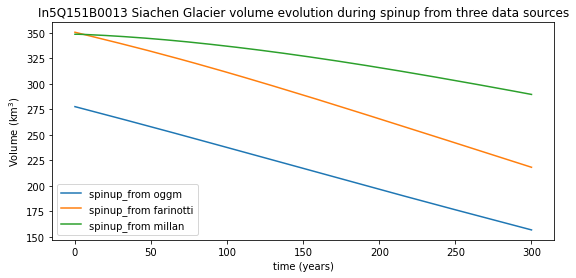

In [41]:
f, ax = plt.subplots(figsize=(9, 4))
for k in range(0,3):
    (d_[k].volume.sum(dim='rgi_id') * 1e-9).plot(ax=ax, label='spinup_from '+data_list[k])

plt.legend()
plt.title(''+gdir.name_corr+' volume evolution during spinup from three data sources')
plt.xlabel('time (years)')
plt.ylabel('Volume ($\mathregular{km^3}$)')
#name = 'evol_spinup_.png'
#plt.savefig(name, format = 'png')

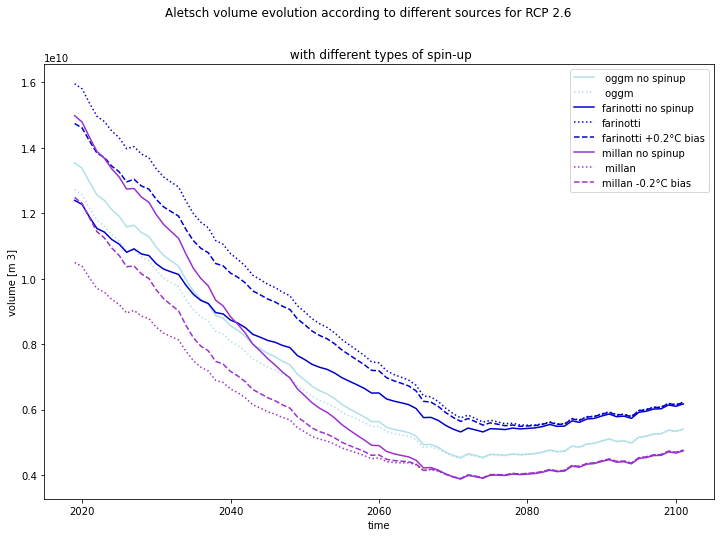

In [66]:
f, ax= plt.subplots(figsize=(12, 8))
rcp=['rcp26','rcp45','rcp60','rcp85']

for data in data_list:
        if (data=='farinotti'):
            out_evol_no_spin[data][0].volume.plot(ax=ax,label=''+data+' no spinup', linestyle="-",color="mediumblue")
            out_evol[data][0].volume.plot(ax=ax,label=''+data, linestyle=":",color="mediumblue")
            #out_evol_m05[data][0].volume.plot(ax=ax,label=''+data+' -0.5°C bias', linestyle="-.",color="b")
            out_evol_p02[data][0].volume.plot(ax=ax,label=''+data+' +0.2°C bias', linestyle="dashed",color="mediumblue")
        elif (data=='millan'):
            out_evol_no_spin[data][0].volume.plot(ax=ax,label=''+data+' no spinup', linestyle="-",color="darkorchid")
            out_evol[data][0].volume.plot(ax=ax,label=' '+data, linestyle=":",color="darkorchid")
            out_evol_m02[data][0].volume.plot(ax=ax,label=''+data+' -0.2°C bias', linestyle="dashed",color="darkorchid")
            #out_evol_p05[data][0].volume.plot(ax=ax,label=''+data+' +0.5°C bias', linestyle="dashed",color="r")
        else:
            out_evol_no_spin[data][0].volume.plot(ax=ax,label=' '+data+' no spinup', linestyle="-",color="powderblue")
            out_evol[data][0].volume.plot(ax=ax,label=' '+data, linestyle=":",color="powderblue")

                    
plt.legend()          
plt.suptitle(''+gdir.name_corr+' volume evolution according to different sources for RCP 2.6')
plt.title(' with different types of spin-up')
name = ''+gdir.name_corr+'_evol_volume_diif_spinup.png'
plt.savefig(name, format = 'png')



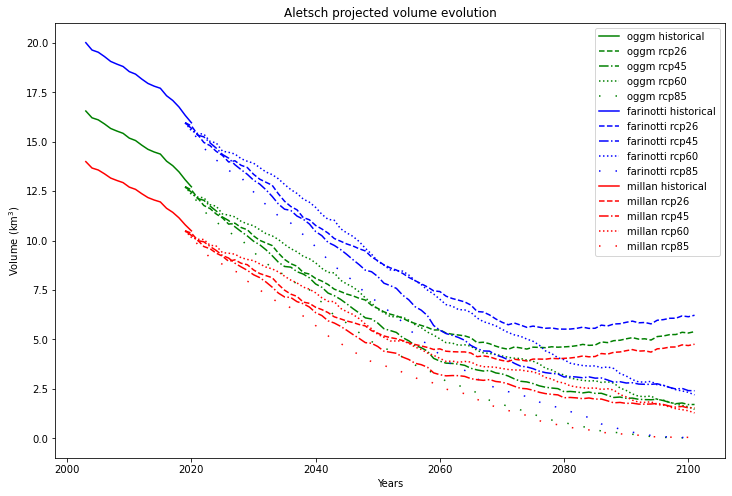

In [10]:
f, ax= plt.subplots(figsize=(12, 8))
rcp=['rcp26','rcp45','rcp60','rcp85']


for data in data_list:
    if (data=='farinotti'):
        color_s="b"
    elif(data=='millan'):
        color_s="r"
    else:
        color_s="g"

    (out_hydro_hist[data].volume_m3*10**-9).plot(ax=ax,label=''+data+' historical', linestyle='-',color=color_s)
    for k in range(0,4):
        if (k==0):
            st='dashed'
        elif (k==1):
            st='-.'
        elif (k==2):
            st=':'
        else:
            st=(0, (1, 10))
            
        (out_evol[data][k].volume*10**-9).plot(ax=ax,label=''+data+' '+rcp[k]+'', linestyle=st,color=color_s)

                    
plt.legend()          
plt.title(''+gdir.name_corr+' projected volume evolution')
plt.xlabel('Years')
plt.ylabel('Volume ($\mathregular{km^3}$)')
name = ''+gdir.name_corr+'_evol_volume_wb.png'
plt.savefig(name, format = 'png')

In [67]:
import pandas as pd
pd.options.plotting.backend = "plotly"
rcp=['rcp26','rcp45','rcp60','rcp85']

#X-axis : time 
tmp=np.linspace(2019,2101,83)

k=0
af1=out_evol_no_spin['farinotti'][k].volume.to_dataframe().volume.to_list()
af2=out_evol['farinotti'][k].volume.to_dataframe().volume.to_list()
af3=out_evol_m02['farinotti'][k].volume.to_dataframe().volume.to_list()
af4=out_evol_p02['farinotti'][k].volume.to_dataframe().volume.to_list()
af5 = out_evol_m04['farinotti'][k].volume.to_dataframe().volume.to_list()
af6 = out_evol_p04['farinotti'][k].volume.to_dataframe().volume.to_list()

am1=out_evol_no_spin['millan'][k].volume.to_dataframe().volume.to_list()
am2=out_evol['millan'][k].volume.to_dataframe().volume.to_list()
am3=out_evol_m02['millan'][k].volume.to_dataframe().volume.to_list()
am4=out_evol_p02['millan'][k].volume.to_dataframe().volume.to_list()
am5=out_evol_m04['millan'][k].volume.to_dataframe().volume.to_list()
am6=out_evol_p04['millan'][k].volume.to_dataframe().volume.to_list()

ao1=out_evol_no_spin['oggm'][k].volume.to_dataframe().volume.to_list()
ao2=out_evol['oggm'][k].volume.to_dataframe().volume.to_list()
ao3=out_evol_m02['oggm'][k].volume.to_dataframe().volume.to_list()
ao4=out_evol_p02['oggm'][k].volume.to_dataframe().volume.to_list()
ao5=out_evol_m04['oggm'][k].volume.to_dataframe().volume.to_list()
ao6=out_evol_p04['oggm'][k].volume.to_dataframe().volume.to_list()

In [68]:
#time
tmp_tot=np.concatenate((tmp,tmp,tmp,tmp,tmp,tmp,tmp,tmp,tmp,tmp,tmp,tmp,tmp,tmp,tmp,tmp,tmp,tmp),axis=0)
#volume
a_tot=np.concatenate((af1,af2,af3,af4,af5,af6,am1,am2,am3,am4,am5,am6,ao1,ao2,ao3,ao4,ao5,ao6),axis=0)/(10**9)

s=len(af1)
#type
t1=['no spinup']*s
t2=['no bias']*s
t3=['-0.2°C bias']*s
t4=['0.2°C bias']*s
t5=['-0.4°C bias']*s
t6=['0.4°C bias']*s

tt=np.concatenate((t1,t2,t3,t4,t5,t6),axis=0)
t_tot=np.concatenate((tt,tt,tt),axis=0)

#data
d1=['Farinotti']*6*s
d2=['Millan']*6*s
d3=['OGGM']*6*s
d_tot=np.concatenate((d1,d2,d3),axis=0)

df= pd.DataFrame({'Years':tmp_tot,'Volume [km3]': a_tot,'Data':d_tot,'Type':t_tot})

In [69]:
import plotly.express as px
fig=px.line(df,y='Volume [km3]',x='Years', color='Data',line_group='Type',line_dash='Type',
            title=""+gdir.name_corr+" volume evolution for RCP 2.6")

fig.show()


In [70]:
fig.write_html('/home/lucillegimenes/'+gdir.name_corr+'_vol_spinups_interactive_'+rcp[k]+'.html')

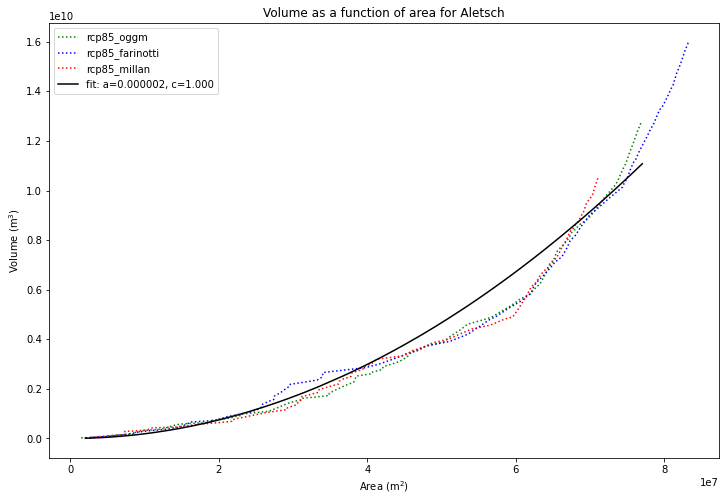

In [71]:
f, ax= plt.subplots(figsize=(12, 8))
rcp=['rcp26','rcp45','rcp60','rcp85']
from scipy.optimize import curve_fit


def func(x, a, c):

    return a * x**2 + c

x_data=[]
y_data=[]
for data in data_list:
    if (data=='farinotti'):
        plt.plot(out_evol[data][3].area,out_evol[data][3].volume,label=''+rcp[3]+'_'+data, linestyle=":",color="b")
    elif (data=='millan'):
        plt.plot(out_evol[data][3].area,out_evol[data][3].volume,label=''+rcp[3]+'_'+data, linestyle=":",color="r")
    else:
        plt.plot(out_evol[data][3].area,out_evol[data][3].volume,label=''+rcp[3]+'_'+data, linestyle=":",color="g")

    x_data.append(out_evol[data][3].sum(dim='rgi_id').area)
    y_data.append(out_evol[data][3].sum(dim='rgi_id').volume)
    
x_data=(x_data[0]+x_data[1]+x_data[2])/3
y_data=(y_data[0]+y_data[1]+y_data[2])/3

popt, pcov = curve_fit(func, x_data, y_data)
plt.plot(x_data,func(x_data,*popt),c="k",label='fit: a=%5.6f, c=%5.3f' % tuple(popt))


plt.xlabel('Area ($\mathregular{m^2}$)')
plt.ylabel('Volume ($\mathregular{m^3}$)')
plt.legend()          
plt.title('Volume as a function of area for '+gdir.name_corr+'')
name = ''+gdir.name_corr+'_evol_ratio_rcp.png'
plt.savefig(name, format = 'png')

Text(0.5, 1.0, ' area evolution ')

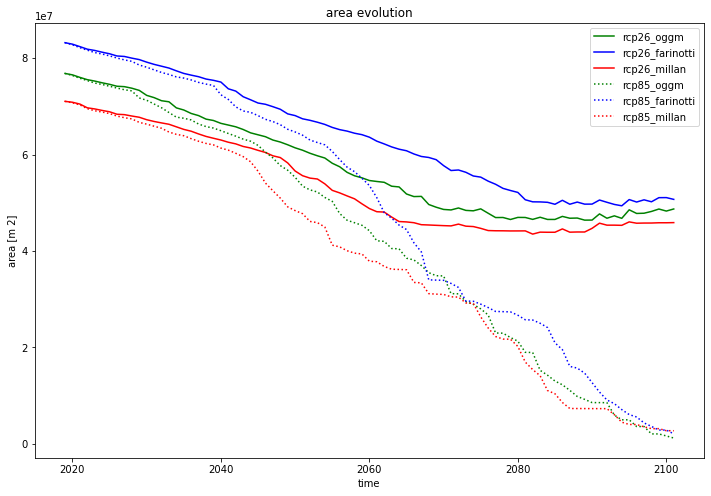

In [72]:
f, ax= plt.subplots(figsize=(12, 8))
rcp=['rcp26','rcp45','rcp60','rcp85']


for k in range(0,4,3):
    for data in data_list:

        if (k==0):
            if (data=='farinotti'):
                out_evol[data][k].area.plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle="-",color="b")
            elif (data=='millan'):
                out_evol[data][k].area.plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle="-",color="r")
            else:
                out_evol[data][k].area.plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle="-",color="g")
        elif (k==1):
            if (data=='farinotti'):
                out_evol[data][k].area.plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle="-.",color="b")
            elif (data=='millan'):
                out_evol[data][k].area.plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle="-.",color="r")
            else:
                out_evol[data][k].area.plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle="-.",color="g")
        elif(k==2):
            if (data=='farinotti'):
                out_evol[data][k].area.plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle="--",color="b")
            elif (data=='millan'):
                out_evol[data][k].area.plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle="--",color="r")
            else:
                out_evol[data][k].area.plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle="--",color="g")
        elif(k==3):
            if (data=='farinotti'):
                out_evol[data][k].area.plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle=":",color="b")
            elif (data=='millan'):
                out_evol[data][k].area.plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle=":",color="r")
            else:
                out_evol[data][k].area.plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle=":",color="g")


plt.legend()          
plt.title(''+gdir.name+' area evolution ')
#name = ''+gdir.name_corr+'_evol_area_rcp.png'
#plt.savefig(name, format = 'png')

In [73]:
import pandas as pd
pd.options.plotting.backend = "plotly"
rcp=['rcp26','rcp45','rcp60','rcp85']

#X-axis : time 
tmp=np.linspace(2019,2101,83)

k=0
af1=out_evol_no_spin['farinotti'][k].area.to_dataframe().area.to_list()
af2=out_evol['farinotti'][k].area.to_dataframe().area.to_list()
af3=out_evol_m02['farinotti'][k].area.to_dataframe().area.to_list()
af4=out_evol_p02['farinotti'][k].area.to_dataframe().area.to_list()
af5 = out_evol_m04['farinotti'][k].area.to_dataframe().area.to_list()
af6 = out_evol_p04['farinotti'][k].area.to_dataframe().area.to_list()

am1=out_evol_no_spin['millan'][k].area.to_dataframe().area.to_list()
am2=out_evol['millan'][k].area.to_dataframe().area.to_list()
am3=out_evol_m02['millan'][k].area.to_dataframe().area.to_list()
am4=out_evol_p02['millan'][k].area.to_dataframe().area.to_list()
am5=out_evol_m04['millan'][k].area.to_dataframe().area.to_list()
am6=out_evol_p04['millan'][k].area.to_dataframe().area.to_list()

ao1=out_evol_no_spin['oggm'][k].area.to_dataframe().area.to_list()
ao2=out_evol['oggm'][k].area.to_dataframe().area.to_list()
ao3=out_evol_m02['oggm'][k].area.to_dataframe().area.to_list()
ao4=out_evol_p02['oggm'][k].area.to_dataframe().area.to_list()
ao5=out_evol_m04['oggm'][k].area.to_dataframe().area.to_list()
ao6=out_evol_p04['oggm'][k].area.to_dataframe().area.to_list()

#time
tmp_tot=np.concatenate((tmp,tmp,tmp,tmp,tmp,tmp,tmp,tmp,tmp,tmp,tmp,tmp,tmp,tmp,tmp,tmp,tmp,tmp),axis=0)
#volume
a_tot=np.concatenate((af1,af2,af3,af4,af5,af6,am1,am2,am3,am4,am5,am6,ao1,ao2,ao3,ao4,ao5,ao6),axis=0)/(10**6)

s=len(af1)
#type
t1=['no spinup']*s
t2=['no bias']*s
t3=['-0.2°C bias']*s
t4=['0.2°C bias']*s
t5=['-0.4°C bias']*s
t6=['0.4°C bias']*s

tt=np.concatenate((t1,t2,t3,t4,t5,t6),axis=0)
t_tot=np.concatenate((tt,tt,tt),axis=0)

#data
d1=['Farinotti']*6*s
d2=['Millan']*6*s
d3=['OGGM']*6*s
d_tot=np.concatenate((d1,d2,d3),axis=0)

df= pd.DataFrame({'Years':tmp_tot,'Area [km2]': a_tot,'Data':d_tot,'Type':t_tot})

In [74]:
import plotly.express as px
fig=px.line(df,y='Area [km2]',x='Years', color='Data',line_group='Type',line_dash='Type',
            title=""+gdir.name_corr+" area evolution for RCP 2.6")

fig.show()

In [75]:
fig.write_html('/home/lucillegimenes/'+gdir.name_corr+'_area_spinups_interactive_'+rcp[k]+'.html')

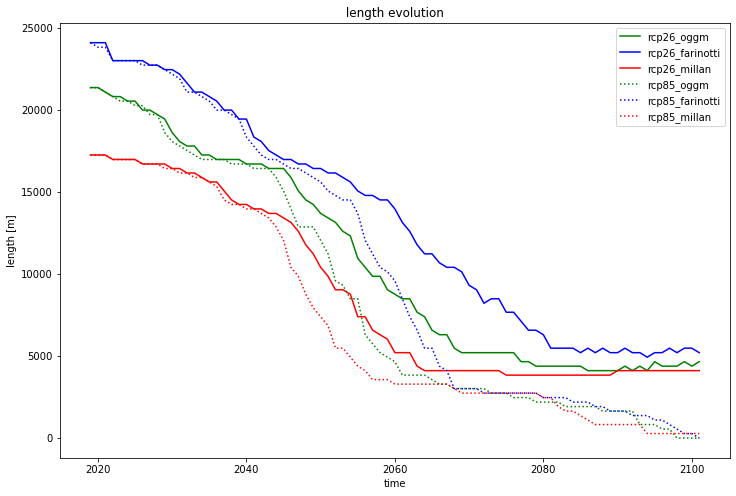

In [76]:
f, ax= plt.subplots(figsize=(12, 8))
rcp=['rcp26','rcp45','rcp60','rcp85']

for k in range(0,4,3):
    for data in data_list:
    
        if (k==0):
            if (data=='farinotti'):
                out_evol[data][k].length.plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle="-",color="b")
            elif (data=='millan'):
                out_evol[data][k].length.plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle="-",color="r")
            else:
                out_evol[data][k].length.plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle="-",color="g")
        elif (k==1):
            if (data=='farinotti'):
                out_evol[data][k].length.plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle="-.",color="b")
            elif (data=='millan'):
                out_evol[data][k].length.plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle="-.",color="r")
            else:
                out_evol[data][k].length.plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle="-.",color="g")
        elif(k==2):
            if (data=='farinotti'):
                out_evol[data][k].length.plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle="--",color="b")
            elif (data=='millan'):
                out_evol[data][k].length.plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle="--",color="r")
            else:
                out_evol[data][k].length.plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle="--",color="g")
        elif(k==3):
            if (data=='farinotti'):
                out_evol[data][k].length.plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle=":",color="b")
            elif (data=='millan'):
                out_evol[data][k].length.plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle=":",color="r")
            else:
                out_evol[data][k].length.plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle=":",color="g")
                    

plt.legend()          
plt.title(''+gdir.name+' length evolution ')
name = ''+gdir.name_corr+'_evol_length_rcp.png'
plt.savefig(name, format = 'png')

### Plotting profile

In [77]:
df_surf=pd.concat([list_out_surf[1],list_out_surf[2],list_out_surf[0]], axis=1)
df_bed=pd.concat([list_out_bed[1],list_out_bed[2],list_out_bed[0]], axis=1)

TypeError: cannot concatenate object of type '<class 'int'>'; only Series and DataFrame objs are valid

In [79]:
df_surf.columns=['farinotti','millan','oggm']
df_bed.columns=['bed farinotti','bed millan','bed oggm']

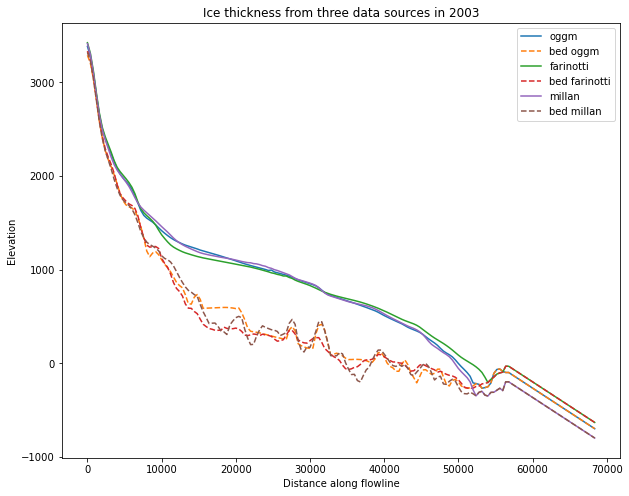

In [80]:
f, ax = plt.subplots(figsize=(10, 8))
for data in data_list:
    df_surf[[data]].plot(ax=ax);
    plt.legend()
    df_bed[['bed '+data+'']].plot(ax=ax,ylabel='Elevation',style="--");
    plt.legend()
plt.title('Ice thickness from three data sources in 2003');
name = ''+gdir.name_corr+'_profil_init.png'
plt.savefig(name, format = 'png')


In [24]:
df_surf_farinotti=pd.concat([list_out_surf_evol[1][0],list_out_surf_evol[1][1],list_out_surf_evol[1][2],
                             list_out_surf_evol[1][3],list_out_surf_evol[1][4],list_out_surf_evol[1][5],
                             list_out_surf_evol[1][6],list_out_surf_evol[1][7]],axis=1)
df_surf_millan=pd.concat([list_out_surf_evol[2][0],list_out_surf_evol[2][1],list_out_surf_evol[2][2],
                          list_out_surf_evol[2][3],list_out_surf_evol[2][4],list_out_surf_evol[2][5],
                          list_out_surf_evol[2][6],list_out_surf_evol[2][7]], axis=1)
df_surf_oggm=pd.concat([list_out_surf_evol[0][0],list_out_surf_evol[0][1],list_out_surf_evol[0][2],
                        list_out_surf_evol[0][3],list_out_surf_evol[0][4],list_out_surf_evol[0][5],
                        list_out_surf_evol[0][6],list_out_surf_evol[0][7]], axis=1)

In [25]:
df_bed_2=pd.concat([list_out_bed_evol[1],list_out_bed_evol[2],list_out_bed_evol[0]], axis=1)

In [26]:
df_bed_2.columns=['bed farinotti','bed millan','bed oggm']


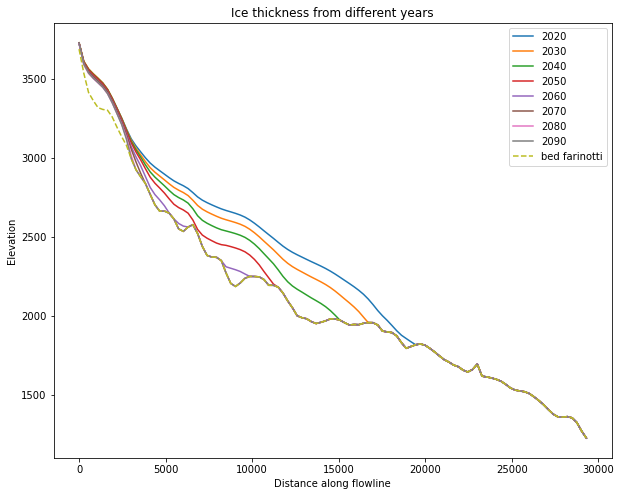

In [27]:
f, ax = plt.subplots(figsize=(10, 8))
for year in [2020,2030,2040,2050,2060,2070,2080,2090]:
    df_surf_farinotti[[year]].plot(ax=ax);
    plt.legend()
df_bed_2[['bed farinotti']].plot(ax=ax,ylabel='Elevation',style="--");
plt.legend()
plt.title('Ice thickness from different years');
name = ''+gdir.name_corr+'_profil_evol_f.png'
plt.savefig(name, format = 'png')


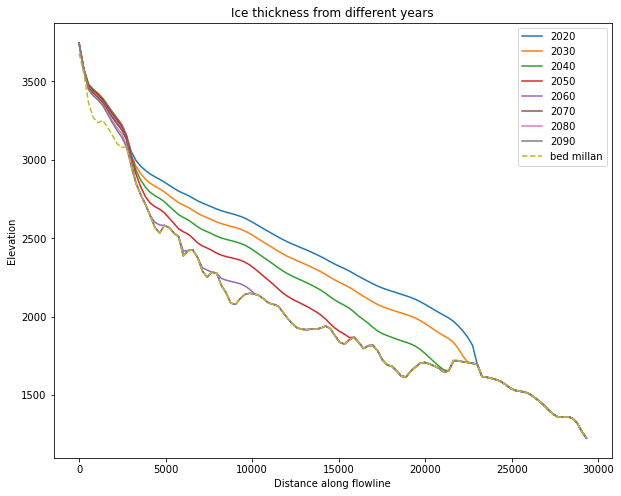

In [28]:
f, ax = plt.subplots(figsize=(10, 8))
for year in [2020,2030,2040,2050,2060,2070,2080,2090]:
    df_surf_millan[[year]].plot(ax=ax);
    plt.legend()
df_bed_2[['bed millan']].plot(ax=ax,ylabel='Elevation',style="--");
plt.legend()
plt.title('Ice thickness from different years');
name = ''+gdir.name_corr+'_profil_evol_m.png'
plt.savefig(name, format = 'png')

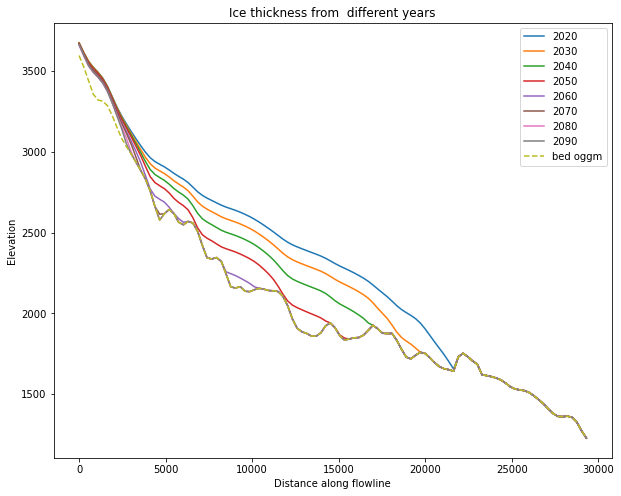

In [29]:
f, ax = plt.subplots(figsize=(10, 8))
for year in [2020,2030,2040,2050,2060,2070,2080,2090]:
    df_surf_oggm[[year]].plot(ax=ax);
    plt.legend()
df_bed_2[['bed oggm']].plot(ax=ax,ylabel='Elevation',style="--");
plt.legend()
plt.title('Ice thickness from  different years');
name = ''+gdir.name_corr+'_profil_evol_o.png'
plt.savefig(name, format = 'png')

### Peak water

In [2]:

pd.options.plotting.backend = "matplotlib"

f, ax = plt.subplots(figsize=(18, 7))
rcp=['rcp26','rcp45','rcp60','rcp85']

                
for data in data_list: #loop all data sources
    
    for k in range(0,4,3): #loop all scenarios

        # Select annual variables
        d_p=out_evol[data][k]
        d_h=out_hydro_hist[data]

        sel_vars = [v for v in d_p.variables if 'month_2d' not in d_p[v].dims]
        sel_vars_hist = [v for v in d_h.variables if 'month_2d' not in d_h[v].dims]
        
        # And create a dataframe
        dp_annual = d_p[sel_vars].to_dataframe()
        dh_annual = d_h[sel_vars_hist].to_dataframe()

        # Select the variables relevant for runoff.
        runoff_vars = ['melt_off_glacier', 'melt_on_glacier','liq_prcp_off_glacier', 'liq_prcp_on_glacier']
        
        dp_runoff = dp_annual[runoff_vars].clip(0) * 1e-9
        dp_runoff = dp_runoff.droplevel('rgi_id')  
        dp_runoff = dp_runoff.drop([2101],axis=0)
        
        dh_runoff = dh_annual[runoff_vars].clip(0) * 1e-9
        dh_runoff = dh_runoff.drop([2020],axis=0)
        
        
        dpt_runoff=pd.concat([dh_runoff,dp_runoff], axis=0)
        
        # Sum the variables each year "axis=1", take the 11 year rolling mean
        # and plot it.
        year_pw=int(dpt_runoff.sum(axis=1).rolling(window=10).mean().idxmax())
        max_pw=dpt_runoff.sum(axis=1).rolling(window=10).mean().max()
        
        #Plotting styles
        if (data=='farinotti'):
            color_s='b'
        elif(data=='millan'):
            color_s='r'
        else:
            color_s='g'
        if (k==0):
            st='-'
        elif(k==3):
            st=':'
        
        dpt_runoff.sum(axis=1).rolling(window=10).mean().plot(ax=ax, label=''+rcp[k]+'_'+data, linestyle=st,color=color_s)
        if (k==0):
            plt.axvline(year_pw, color=color_s, linestyle='dashed', linewidth=1)
            plt.text(year_pw, max_pw, 'yr: {:.2f}, '.format(year_pw)+'pw: {:.2f}'.format(max_pw),bbox=dict(boxstyle="round,pad=0.2", fc="white", ec=color_s, lw=0.5))

plt.xlim(2007,2100)
ax.set_ylabel('Annual runoff (Mt)')
ax.set_xlabel('Year')
plt.title(''+gdir.name_corr+' peak water')
plt.legend();
name = ''+gdir.name_corr+'_peak_water_h&p_combined'
plt.savefig(name, format = 'png')

NameError: name 'pd' is not defined

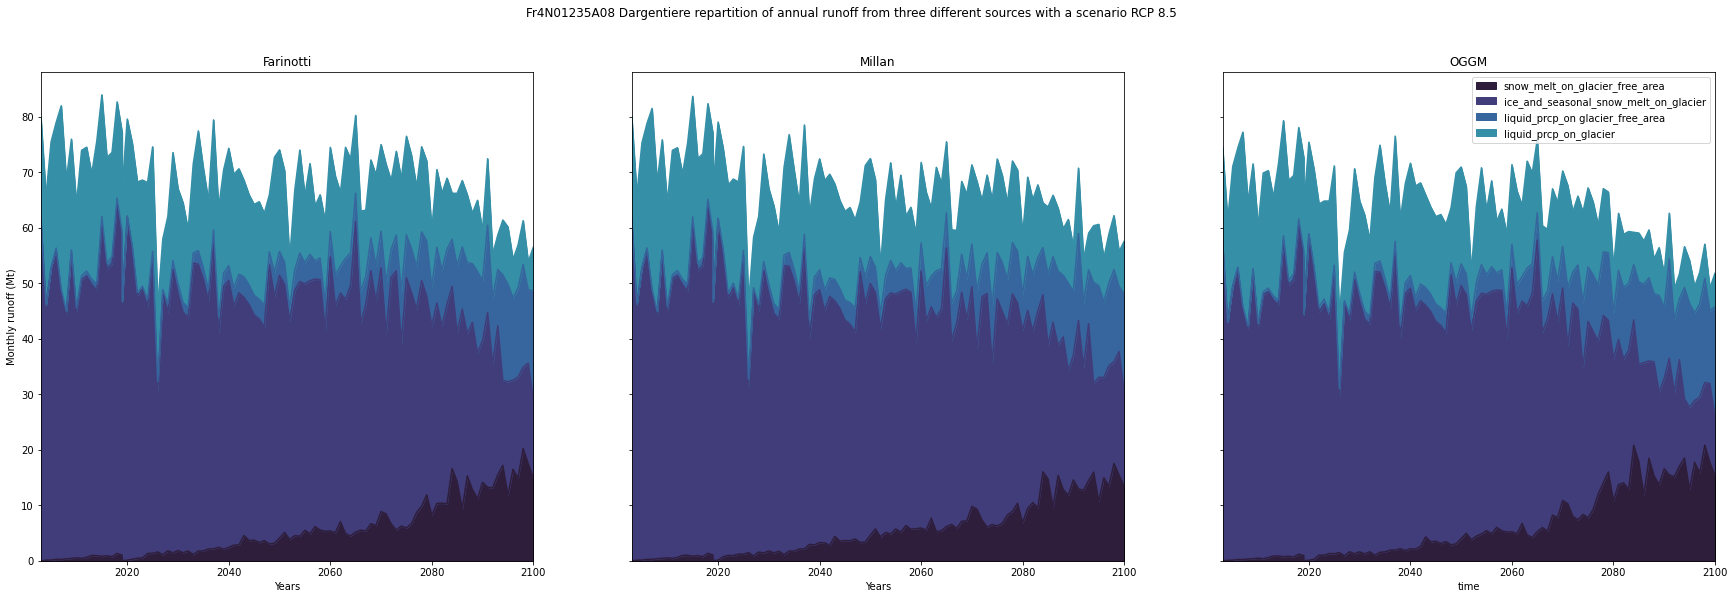

In [33]:
f, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(30, 9),sharey=True)

for data in data_list: #loop all data sources
    d_p=out_evol[data][0]
    d_ptot=d_p
        
    d_h=out_hydro_hist[data]
    d_htot = d_h

    sel_vars = [v for v in d_ptot.variables if 'month_2d' not in d_ptot[v].dims]
    sel_vars_hist = [v for v in d_htot.variables if 'month_2d' not in d_htot[v].dims]
        
    # And create a dataframe
    dp_annual = d_ptot[sel_vars].to_dataframe()
    dh_annual = d_htot[sel_vars_hist].to_dataframe()

    # Select the variables relevant for runoff.
    runoff_vars = ['melt_off_glacier', 'melt_on_glacier','liq_prcp_off_glacier', 'liq_prcp_on_glacier']
        
    dp_runoff = dp_annual[runoff_vars].clip(0) * 1e-9
    dp_runoff = dp_runoff.droplevel('rgi_id') 
    dp_runoff = dp_runoff.drop([2101],axis=0)
        
    dh_runoff = dh_annual[runoff_vars].clip(0) * 1e-9
    dh_runoff = dh_runoff.drop([2020],axis=0)
        
    dp_runoff=pd.concat([dh_runoff,dp_runoff], axis=0) #historical and projections in the same Dataframe
    dp_runoff=dp_runoff.rename(columns={ "melt_off_glacier":"snow_melt_on_glacier_free_area",
                              "melt_on_glacier":"ice_and_seasonal_snow_melt_on_glacier",
                              "liq_prcp_off_glacier":"liquid_prcp_on glacier_free_area",
                              "liq_prcp_on_glacier":"liquid_prcp_on_glacier"})
    
    if (data=='farinotti'):
        dp_runoff.plot.area(ax=ax1, legend=False, title='Farinotti', color=sns.color_palette("mako"));
    elif(data=='millan'):
        dp_runoff.plot.area(ax=ax2, legend=False, title='Millan', color=sns.color_palette("mako")); 
    else:
        dp_runoff.plot.area(ax=ax3, title='OGGM', color=sns.color_palette("mako"));

plt.suptitle(''+gdir.name_corr+' repartition of annual runoff from three different sources with a scenario RCP 8.5')
ax1.set_ylabel('Monthly runoff (Mt)'); ax2.set_ylabel('Monthly runoff (Mt)'); ax3.set_ylabel('Monthly runoff (Mt)')
ax1.set_xlabel('Years'); ax2.set_xlabel('Years'); ax3.set_ylabel('Years')
ax1.set_xlim(2003,2100);ax2.set_xlim(2003,2100);ax3.set_xlim(2003,2100)
ax1.set_ylim(bottom=0);ax2.set_ylim(bottom=0);ax3.set_ylim(bottom=0)

name = ''+gdir.name_corr+'_distrib_runoff__26.png'
plt.savefig(name, format = 'png')

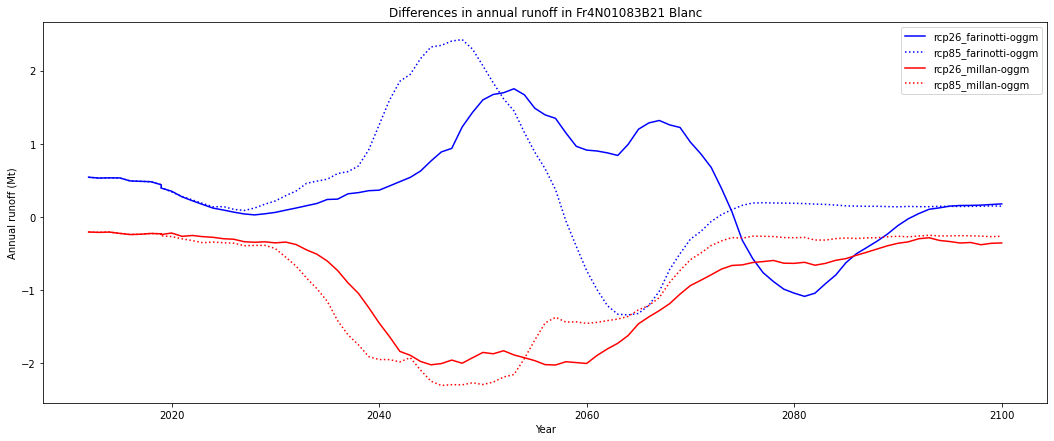

In [15]:
f, ax = plt.subplots(figsize=(18, 7))
rcp=['rcp26','rcp45','rcp60','rcp85']

#oggm reference
runoff_oggm={'rcp26':0,'rcp45':0,'rcp60':0,'rcp85':0}
for k in range(0,4,3): #loop all scenarios
    # Select annual variables
    d_ptot=out_evol['oggm'][k]
        
    d_htot = out_hydro_hist['oggm']

    sel_vars = [v for v in d_ptot.variables if 'month_2d' not in d_ptot[v].dims]
    sel_vars_hist = [v for v in d_htot.variables if 'month_2d' not in d_htot[v].dims]
        
        # And create a dataframe
    dp_annual = d_ptot[sel_vars].to_dataframe()
    dh_annual = d_htot[sel_vars_hist].to_dataframe()

        # Select the variables relevant for runoff.
    runoff_vars = ['melt_off_glacier', 'melt_on_glacier','liq_prcp_off_glacier', 'liq_prcp_on_glacier']
        
    dp_runoff = dp_annual[runoff_vars].clip(0) * 1e-9
    dp_runoff = dp_runoff.droplevel('rgi_id')  
    dp_runoff = dp_runoff.drop([2101],axis=0)
        
    dh_runoff = dh_annual[runoff_vars].clip(0) * 1e-9
    dh_runoff = dh_runoff.drop([2020],axis=0)
        
        
    dp_runoff=pd.concat([dh_runoff,dp_runoff], axis=0)

    if (k==0):
        runoff_oggm['rcp26']=dp_runoff
    elif(k==3):
        runoff_oggm['rcp85']=dp_runoff

for data in ['farinotti','millan']: #loop all data sources
    for k in range(0,4,3): #loop all scenarios
         # Select annual variables
        d_ptot= out_evol[data][k]

        d_htot = out_hydro_hist[data]

        sel_vars = [v for v in d_ptot.variables if 'month_2d' not in d_ptot[v].dims]
        sel_vars_hist = [v for v in d_htot.variables if 'month_2d' not in d_htot[v].dims]
        
        # And create a dataframe
        dp_annual = d_ptot[sel_vars].to_dataframe()
        dh_annual = d_htot[sel_vars_hist].to_dataframe()

        # Select the variables relevant for runoff.
        runoff_vars = ['melt_off_glacier', 'melt_on_glacier','liq_prcp_off_glacier', 'liq_prcp_on_glacier']
        
        dp_runoff = dp_annual[runoff_vars].clip(0) * 1e-9
        dp_runoff = dp_runoff.droplevel('rgi_id')  
        dp_runoff = dp_runoff.drop([2101],axis=0)
        
        dh_runoff = dh_annual[runoff_vars].clip(0) * 1e-9
        dh_runoff = dh_runoff.drop([2020],axis=0)
        
        
        dp_runoff=pd.concat([dh_runoff,dp_runoff], axis=0)
        
        # Sum the variables each year "axis=1", take the 11 year rolling mean
        # and plot it.
        if (k==0):
            diff_runoff=dp_runoff-runoff_oggm['rcp26']
            if (data=='farinotti'):
                diff_runoff.sum(axis=1).rolling(window=10).mean().plot(ax=ax, label=''+rcp[k]+'_'+data+'-oggm', linestyle="-",color="b")
              
            elif(data=='millan'):
                diff_runoff.sum(axis=1).rolling(window=10).mean().plot(ax=ax, label=''+rcp[k]+'_'+data+'-oggm', linestyle="-",color="r")

        elif(k==3):
            diff_runoff=dp_runoff-runoff_oggm['rcp85']
            if (data=='farinotti'):
                diff_runoff.sum(axis=1).rolling(window=10).mean().plot(ax=ax, label=''+rcp[k]+'_'+data+'-oggm', linestyle=":",color="b")
                                      
            elif(data=='millan'):
                diff_runoff.sum(axis=1).rolling(window=10).mean().plot(ax=ax, label=''+rcp[k]+'_'+data+'-oggm', linestyle=":",color="r")
               
         
ax.set_ylabel('Annual runoff (Mt)')
ax.set_xlabel('Year')
plt.title('Differences in annual runoff in '+gdir.name_corr+'')
plt.legend();
name = ''+gdir.name_corr+'_peak_water_diff.png'
plt.savefig(name, format = 'png')

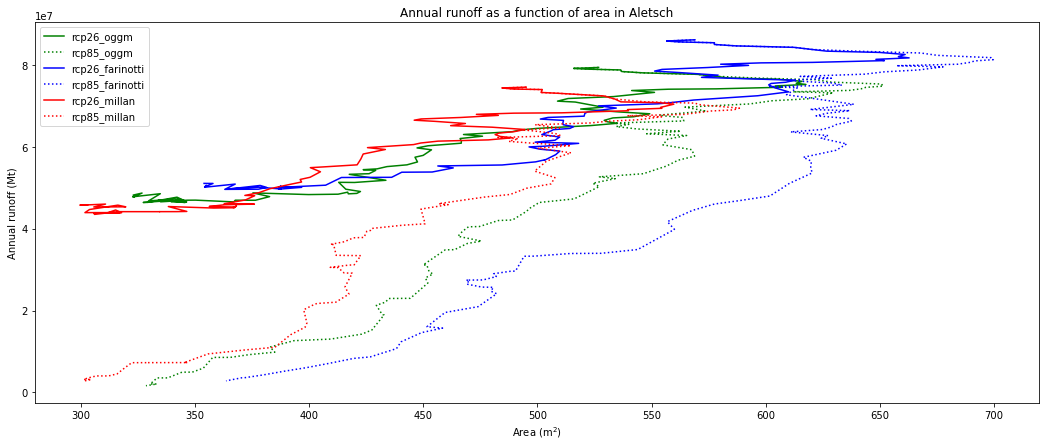

In [22]:
f, ax = plt.subplots(figsize=(18, 7))
rcp=['rcp26','rcp45','rcp60','rcp85']

for data in data_list: #loop all data sources
    for k in range(0,4,3): #loop all scenarios
         # Select annual variables
        d_ptot=out_evol[data][k]
        d_htot = out_hydro_hist[data]

        sel_vars = [v for v in d_ptot.variables if 'month_2d' not in d_ptot[v].dims]
        sel_vars_hist = [v for v in d_htot.variables if 'month_2d' not in d_htot[v].dims]
        
        # And create a dataframe
        dp_annual = d_ptot[sel_vars].to_dataframe()
        dh_annual = d_htot[sel_vars_hist].to_dataframe()

        # Select the variables relevant for runoff.
        runoff_vars = ['melt_off_glacier', 'melt_on_glacier','liq_prcp_off_glacier', 'liq_prcp_on_glacier']
        
        dp_runoff = dp_annual[runoff_vars].clip(0) * 1e-9
        dp_runoff = dp_runoff.droplevel('rgi_id')  
        dp_runoff = dp_runoff.drop([2101],axis=0)
        
        dh_runoff = dh_annual[runoff_vars].clip(0) * 1e-9
        dh_runoff = dh_runoff.drop([2020],axis=0)
        
        
        dp_runoff=pd.concat([dh_runoff,dp_runoff], axis=0)
        
        dp_area = dp_annual
        dh_area = dh_annual
        dp_area = dp_area['area'].clip(0)
        dp_area = dp_area.drop([2101],axis=0)
        dh_area = dh_area['area_m2'].clip(0)
        dh_area = dh_area.drop([2020],axis=0)
            
        d_area = pd.concat([dh_area,dp_area],axis=0)

        if (k==0):
            if (data=='farinotti'):
                plt.plot(dp_runoff.sum(axis=1).rolling(window=10).mean(),d_area,label=''+rcp[k]+'_'+data, linestyle="-",color="b")
            elif(data=='millan'):
                plt.plot(dp_runoff.sum(axis=1).rolling(window=10).mean(),d_area,label=''+rcp[k]+'_'+data, linestyle="-",color="r")
            else:
                plt.plot(dp_runoff.sum(axis=1).rolling(window=10).mean(),d_area,label=''+rcp[k]+'_'+data, linestyle="-",color="g")
        elif(k==3):
            if (data=='farinotti'):
                plt.plot(dp_runoff.sum(axis=1).rolling(window=10).mean(),d_area,label=''+rcp[k]+'_'+data, linestyle=":",color="b")                          
            elif(data=='millan'):
                plt.plot(dp_runoff.sum(axis=1).rolling(window=10).mean(),d_area,label=''+rcp[k]+'_'+data, linestyle=":",color="r")
            else:
                plt.plot(dp_runoff.sum(axis=1).rolling(window=10).mean(),d_area,label=''+rcp[k]+'_'+data, linestyle=":",color="g")
         
ax.set_ylabel('Annual runoff (Mt)')

plt.xlabel('Area ($\mathregular{m^2}$)')
plt.title('Annual runoff as a function of area in '+gdir.name_corr+'')
plt.legend();
name = ''+gdir.name_corr+' peak_water-area.png'
plt.savefig(name, format = 'png')